c:\users\dishant\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


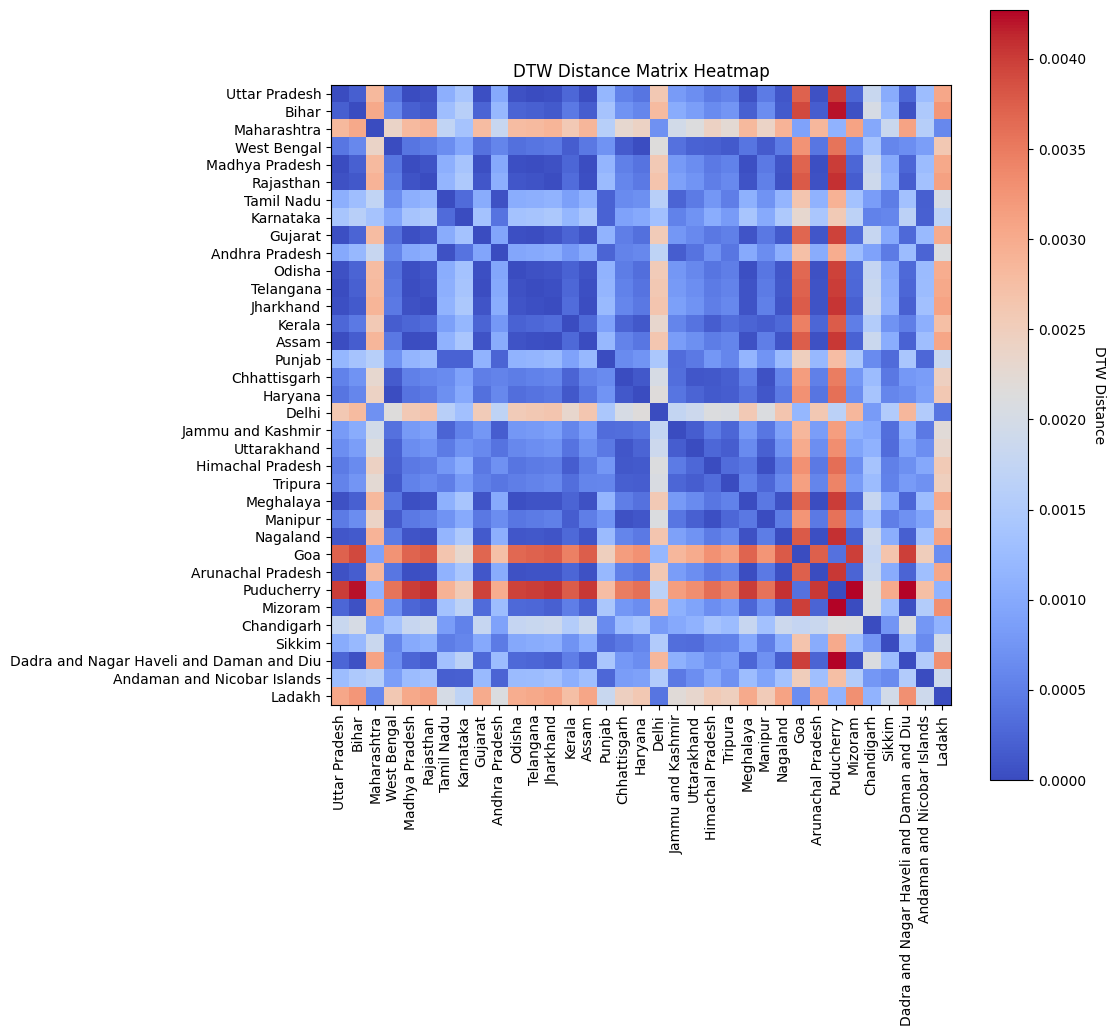

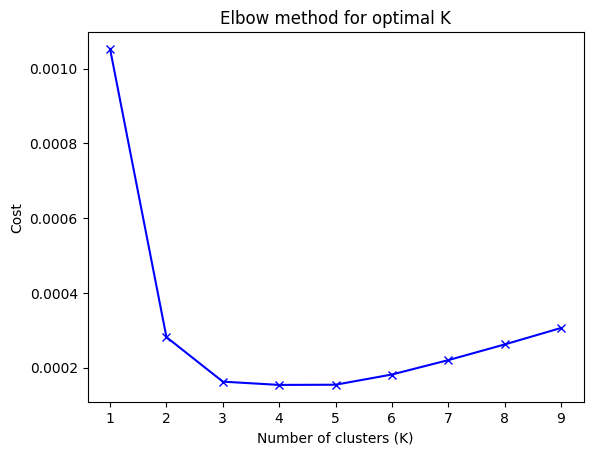

Optimum number of clusters: 4


c:\users\dishant\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:92: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


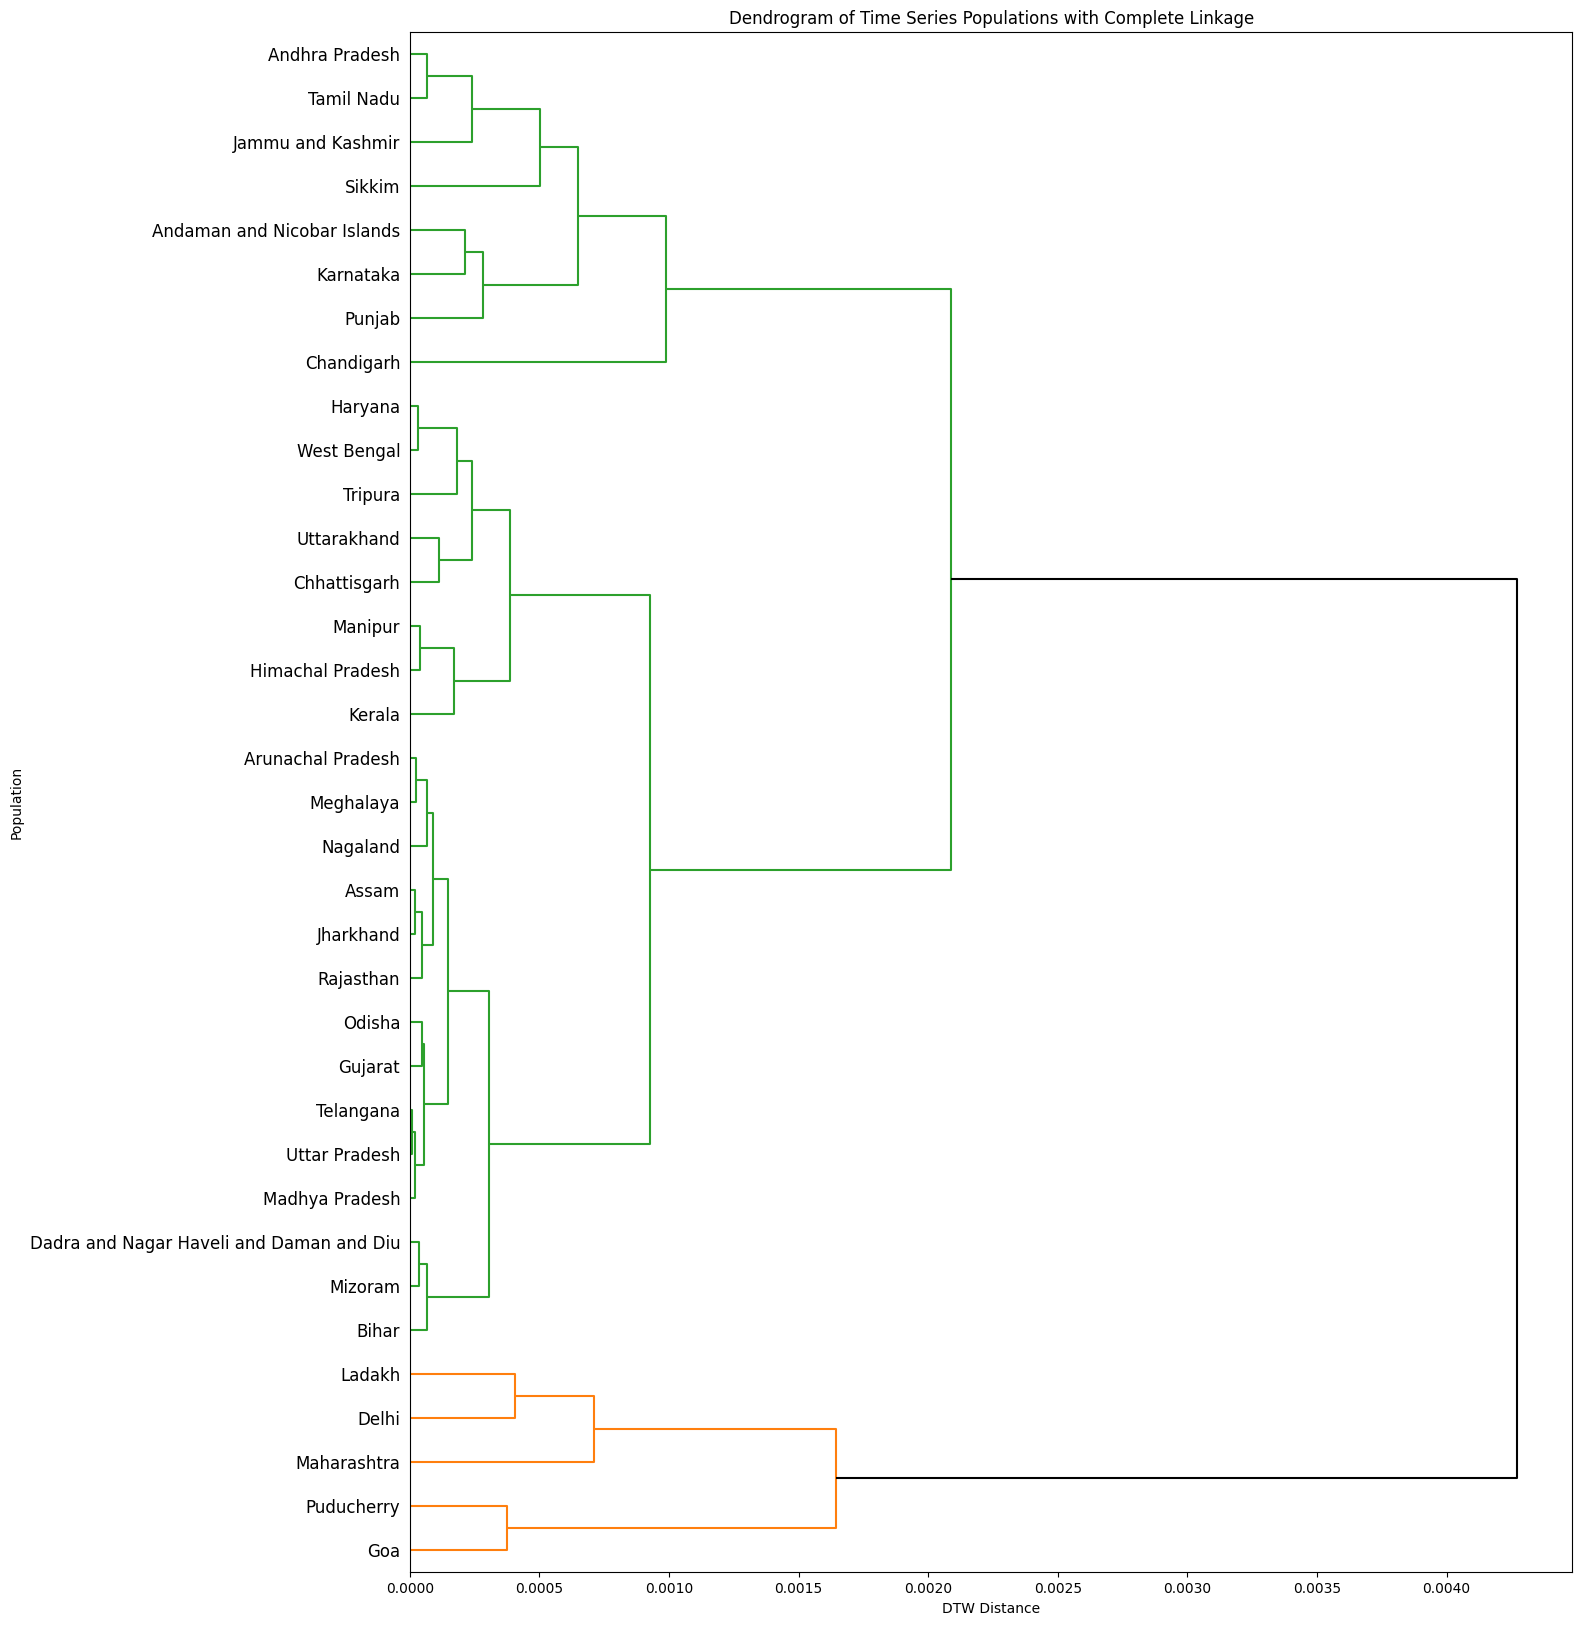

In [1]:
import pandas as pd
from tslearn.metrics import dtw
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from kneed import KneeLocator
from scipy.cluster.hierarchy import dendrogram, linkage

df = pd.read_csv(r"C:\Users\Dishant\Desktop\Untitled Folder\states.csv")

# Filter data for desired time period
start_date = '2020-07-01'
end_date = '2020-12-31'
mask = (df['Date'] >= start_date) & (df['Date'] <= end_date)
df = df.loc[mask]

# Calculate case rates for each state
# Read population.csv file
dp = pd.read_csv(r"C:\Users\Dishant\Desktop\Untitled Folder\population.csv")

# Remove commas from Population column
dp['Population'] = dp['Population'].str.replace(',', '')

# Create a dictionary with state names as keys and population as values
populations = dict(zip(dp['State'], dp['Population'].astype(int)))
mortality_rates = {}
for state in populations:
    state_df = df.loc[df['State'] == state]
    first_day_deceased = state_df.loc[state_df['Date'] >= start_date]['Deceased'].iloc[0]
    state_df['Mortality Rate'] = (state_df['Deceased'] - first_day_deceased) / populations[state]
    mortality_rates[state] = state_df[['Date', 'Mortality Rate']].reset_index(drop=True)
    # Update the original df with the 'Mortality Rate' column
    df.loc[df['State'] == state, 'Mortality Rate'] = state_df['Mortality Rate']


# assuming your case rate time series data is stored in a dataframe called 'df' with columns 'state' and 'case_rate'
mortality_rates = []
for state in populations:
    state_mortality_rates = df.loc[df['State'] == state]['Mortality Rate'].values
    mortality_rates.append(state_mortality_rates)

# calculate DTW distance matrix
dtw_dist_matrix = np.zeros((len(populations), len(populations)))
for i in range(len(populations)):
    for j in range(i+1, len(populations)):
        dtw_dist_matrix[i][j] = dtw(mortality_rates[i], mortality_rates[j], sakoe_chiba_radius=7)
        dtw_dist_matrix[j][i] = dtw_dist_matrix[i][j]
        
# Plot heatmap of dtw distance matrix
fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(dtw_dist_matrix, cmap='coolwarm')

# Set x and y axis labels
ax.set_xticks(np.arange(len(populations)))
ax.set_yticks(np.arange(len(populations)))
ax.set_xticklabels(populations, rotation=90)
ax.set_yticklabels(populations)

# Create colorbar legend
cbar = ax.figure.colorbar(im, ax=ax)
cbar.ax.set_ylabel("DTW Distance", rotation=-90, va="bottom")

# Set plot title
ax.set_title("DTW Distance Matrix Heatmap")

# Show plot
plt.show()

# Calculate cost function for different values of K
costs = []
Ks = range(1, 10)
for K in Ks:
    kmeans = KMeans(n_clusters=K)
    kmeans.fit(dtw_dist_matrix)
    costs.append(kmeans.inertia_ + 0.15e-4*K*np.log(K))

# Plot the cost function vs. K
plt.plot(Ks, costs, 'bx-')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Cost')
plt.title('Elbow method for optimal K')
plt.show()

# optimum number of clusters
for i in range(9):
    if costs[i]==min(costs):
        print(f'Optimum number of clusters:', i+1)
    else:
        continue

# Calculate linkage matrix using complete linkage
linkage_matrix = linkage(dtw_dist_matrix, method='complete')

from scipy.spatial.distance import squareform

# Convert to condensed distance matrix
condensed_dist_matrix = squareform(dtw_dist_matrix)

# Compute linkage matrix using complete linkage
linkage_matrix = linkage(condensed_dist_matrix, method='complete')

# Plot dendrogram
fig, ax = plt.subplots(figsize=(15, 20))
dendrogram(linkage_matrix, labels=list(populations.keys()), orientation='right', color_threshold=None, above_threshold_color='k', leaf_font_size=12, leaf_rotation=0)
# Set plot title and labels
plt.title('Dendrogram of Time Series Populations with Complete Linkage')
plt.xlabel('DTW Distance')
plt.ylabel('Population')
plt.show()


c:\users\dishant\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


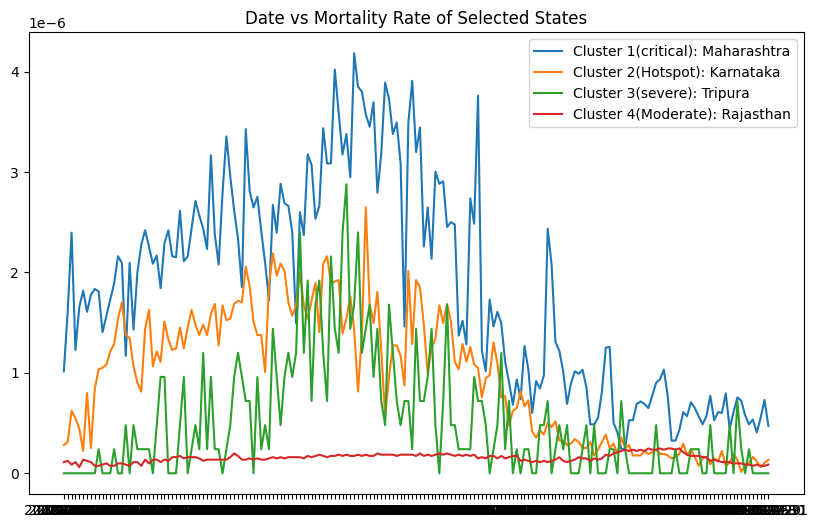

In [2]:
# Select the desired states
states = ['Maharashtra', 'Karnataka', 'Tripura', 'Rajasthan']

# Create a list of dictionaries containing the case rate data for each state
mortality_rates = []
for state in states:
    state_df = df.loc[df['State'] == state]
    state_df['Mortality Rate'] = state_df['Deceased'].diff().fillna(state_df['Deceased'])/ populations[state]
    state_data = {
        'State': state,
        'Mortality Rate': state_df[['Date', 'Mortality Rate']].reset_index(drop=True)
    }
    mortality_rates.append(state_data)

# Create a figure and axis object
fig, ax = plt.subplots(figsize=(10, 6))

# Loop over each state and plot the date vs case rate
for state in mortality_rates:
    state_name = state['State']
    state_df = state['Mortality Rate']
    
    # Add labels based on the state
    if state_name == 'Maharashtra':
        ax.plot(state_df['Date'].iloc[1:], state_df['Mortality Rate'].iloc[1:], label='Cluster 1(critical): Maharashtra')
    elif state_name == 'Karnataka':
        ax.plot(state_df['Date'].iloc[1:], state_df['Mortality Rate'].iloc[1:], label='Cluster 2(Hotspot): Karnataka')
    elif state_name == 'Tripura':
        ax.plot(state_df['Date'].iloc[1:], state_df['Mortality Rate'].iloc[1:], label='Cluster 3(severe): Tripura')
    elif state_name == 'Rajasthan':
        ax.plot(state_df['Date'].iloc[1:], state_df['Mortality Rate'].iloc[1:], label='Cluster 4(Moderate): Rajasthan')

# Add a title and legend to the plot
ax.set_title('Date vs Mortality Rate of Selected States')
ax.legend()

# Show the plot
plt.show()

c:\users\dishant\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


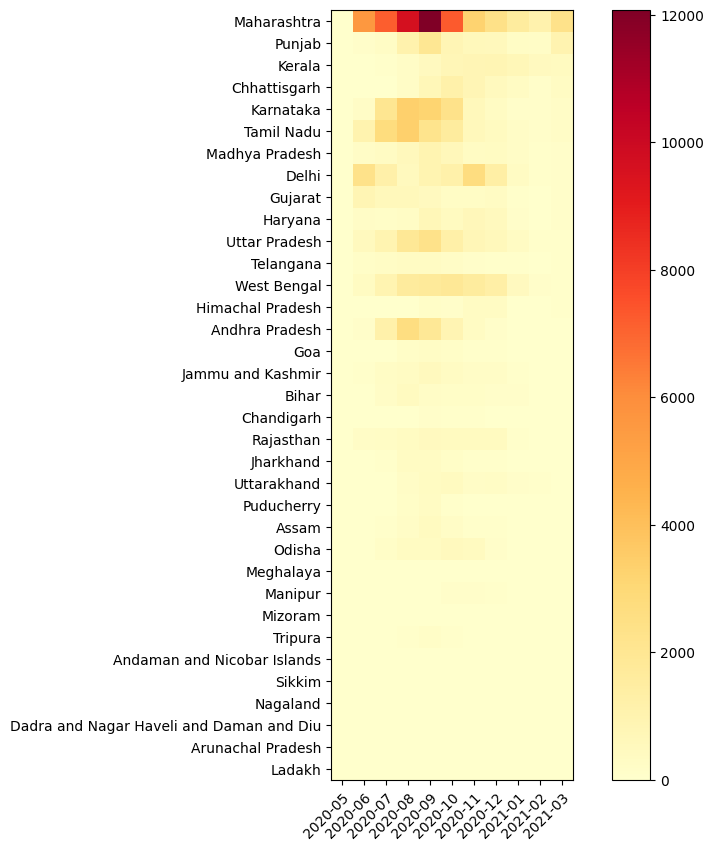

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv(r"C:\Users\Dishant\Desktop\Untitled Folder\states.csv")

# Filter data for desired time period
start_date = '2020-05-01'
end_date = '2021-03-30'
mask = (df['Date'] >= start_date) & (df['Date'] <= end_date)
df = df.loc[mask]

dp = pd.read_csv(r"C:\Users\Dishant\Desktop\Untitled Folder\population.csv")

# Remove commas from Population column
dp['Population'] = dp['Population'].str.replace(',', '')

# Create a dictionary with state names as keys and population as values
populations = dict(zip(dp['State'], dp['Population'].astype(int)))

# Calculate monthly deaths for each state
monthly_deaths = {}
for state in populations:
    state_df = df.loc[df['State'] == state]
    state_df['Monthly'] = pd.to_datetime(state_df['Date']).dt.to_period('M')
    monthly_deaths[state] = state_df.groupby('Monthly')['Deceased'].max().diff().fillna(0)

# Create a pivot table with the mean monthly deaths for each state
mean_monthly_deaths = pd.pivot_table(pd.concat(monthly_deaths, axis=1), index='Monthly', aggfunc='mean').T

# Sort the states by their mean monthly deaths in ascending order
mean_monthly_deaths = mean_monthly_deaths.sort_values(by=mean_monthly_deaths.columns[-1], ascending=False)

# Create the heatmap
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(mean_monthly_deaths.values, cmap='YlOrRd')

# Customize the heatmap
ax.set_xticks(np.arange(len(mean_monthly_deaths.columns)))
ax.set_yticks(np.arange(len(mean_monthly_deaths.index)))
ax.set_xticklabels(mean_monthly_deaths.columns)
ax.set_yticklabels(mean_monthly_deaths.index)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.colorbar(im)
plt.show()

c:\users\dishant\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


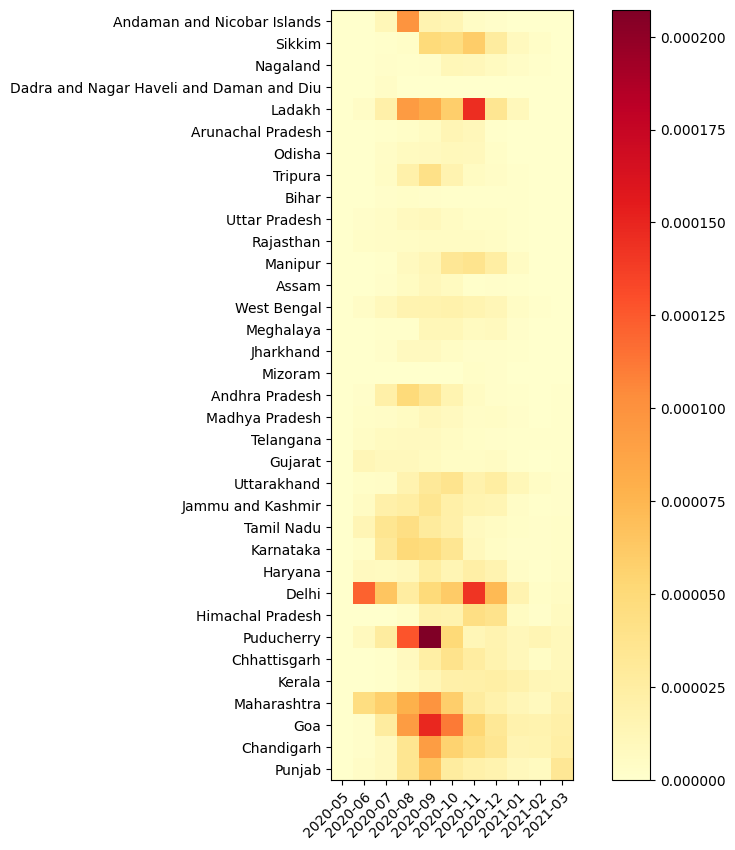

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv(r"C:\Users\Dishant\Desktop\Untitled Folder\states.csv")

# Filter data for desired time period
start_date = '2020-05-01'
end_date = '2021-03-30'
mask = (df['Date'] >= start_date) & (df['Date'] <= end_date)
df = df.loc[mask]

dp = pd.read_csv(r"C:\Users\Dishant\Desktop\Untitled Folder\population.csv")

# Remove commas from Population column
dp['Population'] = dp['Population'].str.replace(',', '')

# Create a dictionary with state names as keys and population as values
populations = dict(zip(dp['State'], dp['Population'].astype(int)))

# Calculate monthly deaths for each state
monthly_deaths = {}
for state in populations:
    state_df = df.loc[df['State'] == state]
    state_df['Monthly'] = pd.to_datetime(state_df['Date']).dt.to_period('M')
    a = state_df.groupby('Monthly')['Deceased'].max().diff().fillna(0)
    monthly_deaths[state] = a / populations[state]

# Create a pivot table with the mean monthly deaths for each state
mean_monthly_deaths = pd.pivot_table(pd.concat(monthly_deaths, axis=1), index='Monthly', aggfunc='mean').T

# Sort the states by their mean monthly deaths in ascending order
mean_monthly_deaths = mean_monthly_deaths.sort_values(by=mean_monthly_deaths.columns[-1])

# Create the heatmap
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(mean_monthly_deaths.values, cmap='YlOrRd')

# Customize the heatmap
ax.set_xticks(np.arange(len(mean_monthly_deaths.columns)))
ax.set_yticks(np.arange(len(mean_monthly_deaths.index)))
ax.set_xticklabels(mean_monthly_deaths.columns)
ax.set_yticklabels(mean_monthly_deaths.index)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.colorbar(im)
plt.show()